In [3]:
# Analyse comparative des deux outils STAR & featureCounts :
# install :

In [ ]:
ls

import pandas as pd

star_df = pd.read_csv("./count_star/gene_count_matrix_STAR.csv", index_col="Geneid")
fc_df = pd.read_csv("./count_featurecounts/gene_count_matrix_featurecounts.csv", index_col="Geneid")

print("Matrice STAR shape:", star_df.shape)
print("Matrice featureCounts shape:", fc_df.shape)

Matrice STAR shape: (18, 45)
Matrice featureCounts shape: (18, 45)


In [5]:
common_genes = star_df.index.intersection(fc_df.index)
star_common = star_df.loc[common_genes]
fc_common = fc_df.loc[common_genes]

star_common.columns = [f"{col}_STAR" for col in star_common.columns]
fc_common.columns = [f"{col}_FC" for col in fc_common.columns]

# fussion > les deux matrices
merged_df = pd.concat([star_common, fc_common], axis=1)
merged_df.to_csv("./merged_gene_counts.csv")
print("Matrices fusionnées et sauvegardées dans merged_gene_counts.csv")

Matrices fusionnées et sauvegardées dans merged_gene_counts.csv


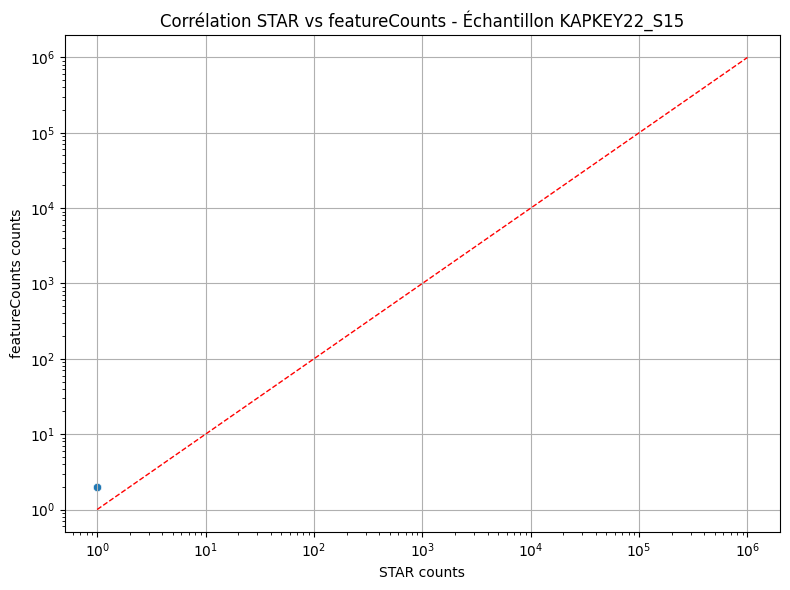

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns


star_samples = [col[:-5] for col in merged_df.columns if col.endswith('_STAR')]
fc_samples = [col[:-3] for col in merged_df.columns if col.endswith('_FC')]
common_samples = list(set(star_samples) & set(fc_samples))
if not common_samples:
	raise ValueError("Aucun échantillon commun trouvé entre STAR et FC.")

sample_name = common_samples[0]
star_col = f"{sample_name}_STAR"
fc_col = f"{sample_name}_FC"

# Plot scatterplot
plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df[[star_col, fc_col]], x=star_col, y=fc_col)
plt.xscale('log')
plt.yscale('log')
plt.title(f"Corrélation STAR vs featureCounts - Échantillon {sample_name}")
plt.xlabel("STAR counts")
plt.ylabel("featureCounts counts")
plt.plot([1, 1e6], [1, 1e6], 'r--', lw=1)
plt.grid(True)
plt.tight_layout()
#plt.savefig("correlation_STAR_vs_FC.png", dpi=300)
plt.show()

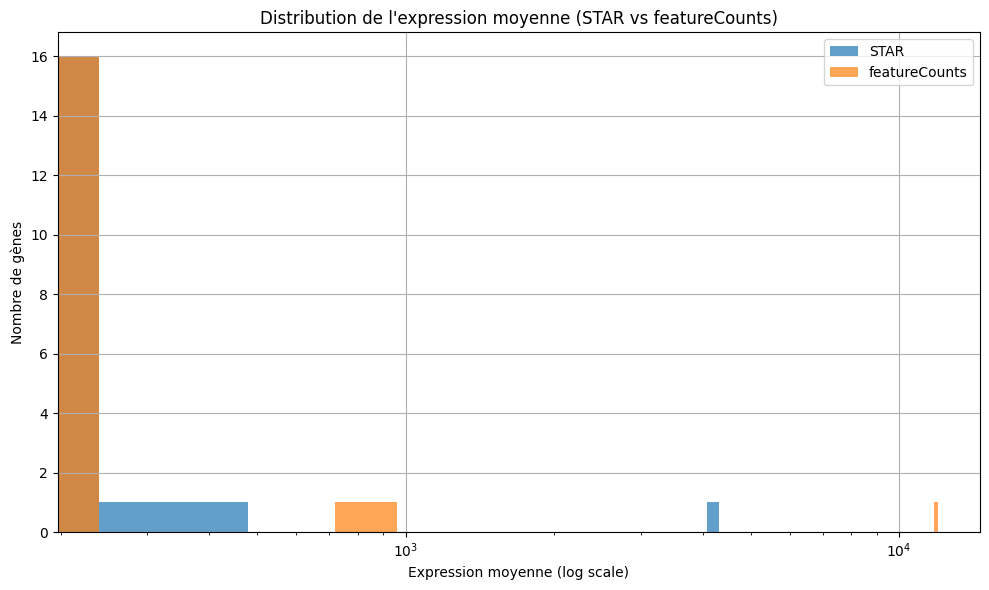

In [7]:
# Calculer l'expression moyenne
merged_df['mean_STAR'] = merged_df[[c for c in merged_df.columns if '_STAR' in c]].mean(axis=1)
merged_df['mean_FC'] = merged_df[[c for c in merged_df.columns if '_FC' in c]].mean(axis=1)

# Plot avec log
merged_df[['mean_STAR', 'mean_FC']].plot(kind='hist', bins=50, figsize=(10, 6), alpha=0.7, logx=True)
plt.title("Distribution de l'expression moyenne (STAR vs featureCounts)")
plt.xlabel("Expression moyenne (log scale)")
plt.ylabel("Nombre de gènes")
plt.legend(['STAR', 'featureCounts'])
plt.grid(True)
plt.tight_layout()
#plt.savefig("distribution_expression_moyenne.png", dpi=300)
plt.show()

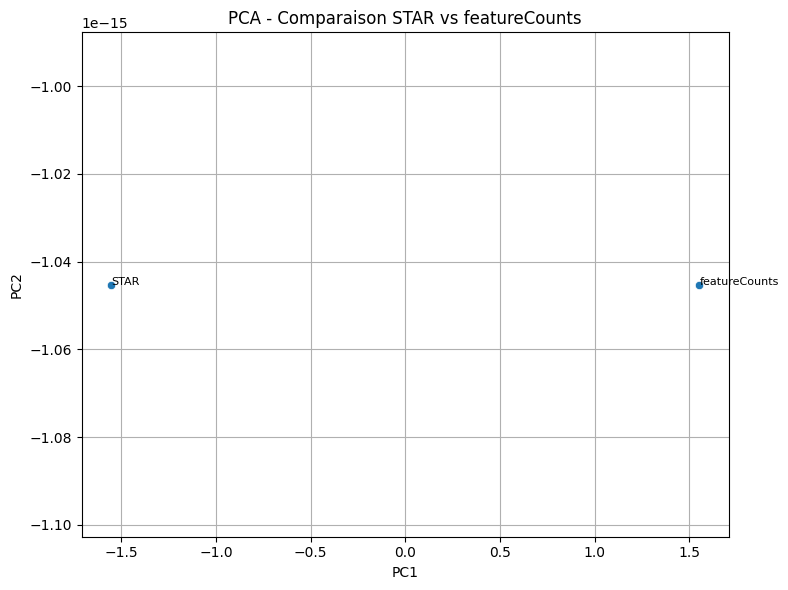

In [8]:
from sklearn.decomposition import PCA
import numpy as np

# Log transform + PCA pour STAR
star_log = np.log(star_df.sum(axis=1).to_frame('STAR') + 1)
fc_log = np.log(fc_df.sum(axis=1).to_frame('featureCounts') + 1)

pca_df = pd.concat([star_log, fc_log], axis=1)

pca = PCA(n_components=2)
pca_result = pca.fit_transform(pca_df.T)  # Échantillons en colonnes → transpose

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_result[:, 0], y=pca_result[:, 1])
for i, txt in enumerate(pca_df.columns):
    plt.annotate(txt, (pca_result[i, 0], pca_result[i, 1]), fontsize=8)
plt.title("PCA - Comparaison STAR vs featureCounts")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.grid(True)
plt.tight_layout()
#plt.savefig("pca_STAR_vs_FC.png", dpi=300)
plt.show()

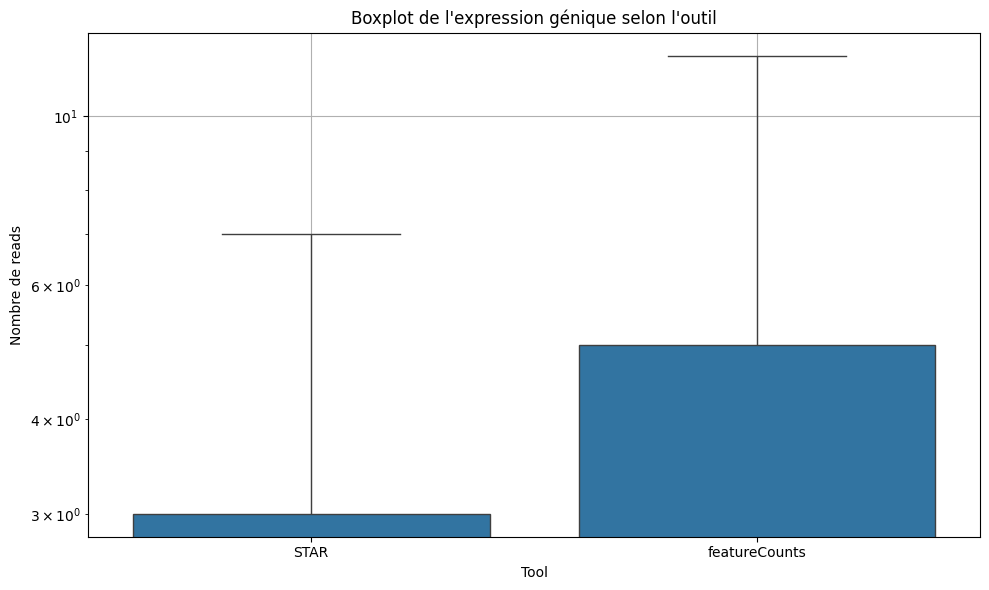

In [9]:
# Ajouter une colonne type d’outil
merged_df['Gene'] = merged_df.index
df_melted = merged_df.melt(id_vars=['Gene'], value_vars=merged_df.columns.tolist(),
                           var_name='Sample', value_name='Count')
df_melted['Tool'] = df_melted['Sample'].apply(lambda x: "STAR" if "_STAR" in x else "featureCounts")

# Plot boxplot
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_melted, x='Tool', y='Count', showfliers=False)
plt.yscale('log')
plt.title("Boxplot de l'expression génique selon l'outil")
plt.ylabel("Nombre de reads")
plt.grid(True)
plt.tight_layout()
#plt.savefig("boxplot_STAR_vs_FC.png", dpi=300)
plt.show()

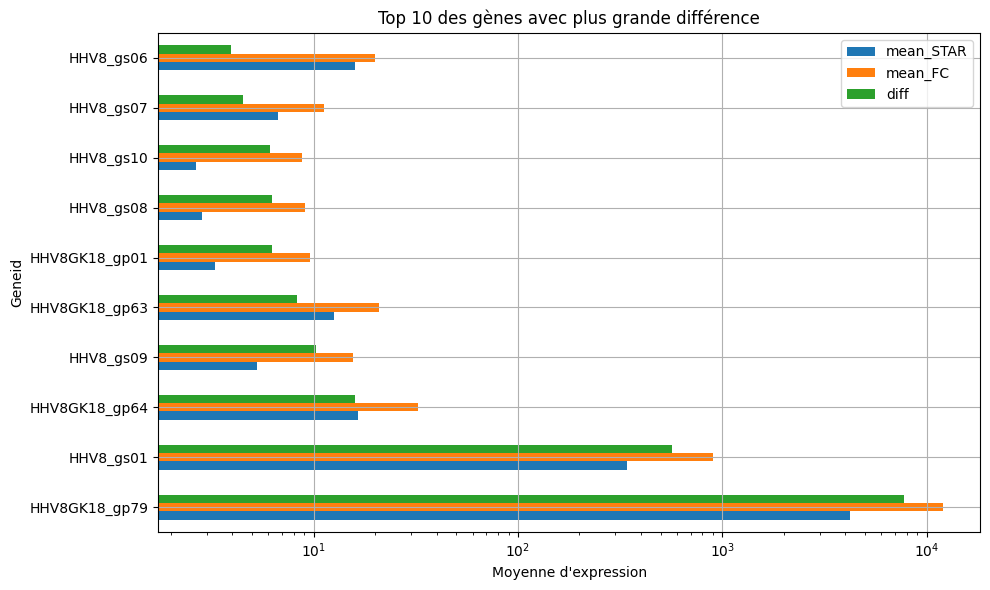

In [10]:
summary_table = pd.DataFrame({
    'mean_STAR': star_df.mean(axis=1),
    'mean_FC': fc_df.mean(axis=1),
    'diff': abs(star_df.mean(axis=1) - fc_df.mean(axis=1)),
}).sort_values(by='diff', ascending=False)

summary_table.head(10).plot(kind='barh', figsize=(10, 6), title="Top 10 des gènes avec plus grande différence")
plt.xscale('log')
plt.xlabel("Moyenne d'expression")
plt.grid(True)
plt.tight_layout()
#plt.savefig("top_diff_genes.png", dpi=300)
plt.show()